In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:4"

In [3]:
import torch
import abc
from typing import Union, Tuple
from diffusers import DDIMScheduler
from utils import load_image_data, load_image, pil_to_tensor
import matplotlib.pyplot as plt

"""
Util functions based on Diffuser framework and Masactrl.
"""


import os
import torch
import cv2
import numpy as np

import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image

from diffusers import StableDiffusionPipeline

In [4]:
class EmptyControl:

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if self.LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward(self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            h = attn.shape[0]
            attn[h // 2 :] = self.forward(attn[h // 2 :], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            # self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0
        self.LOW_RESOURCE = False


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {
            "down_cross": [],
            "mid_cross": [],
            "up_cross": [],
            "down_self": [],
            "mid_self": [],
            "up_self": [],
        }

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        # if attn.shape[1] <= 16 ** 2:  # avoid memory overhead
        #     self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):

                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {
            key: [item / self.cur_step for item in self.attention_store[key]]
            for key in self.attention_store
        }
        return average_attention

    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class SelfAttentionControlEdit(AttentionStore, abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def replace_self_attention(self, attn_base, att_replace, place_in_unet):
        if att_replace.shape[2] <= 32**2:
            attn_base = attn_base.unsqueeze(0).expand(
                att_replace.shape[0], *attn_base.shape
            )
            return attn_base
        else:
            return att_replace

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(SelfAttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (
            self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]
        ):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                pass
            else:
                attn[1:] = self.replace_self_attention(
                    attn_base, attn_repalce, place_in_unet
                )
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(
        self,
        prompts,
        num_steps: int,
        self_replace_steps: Union[float, Tuple[float, float]],
    ):
        super(SelfAttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(
            num_steps * self_replace_steps[1]
        )

In [5]:
def register_attention_control_new(model, controller):
    def ca_forward(self, place_in_unet):
        to_out = self.to_out
        if type(to_out) is torch.nn.modules.container.ModuleList:
            to_out = self.to_out[0]
        else:
            to_out = self.to_out

        def forward(hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
            x = hidden_states
            context = encoder_hidden_states
            mask = attention_mask
            batch_size, sequence_length, dim = x.shape
            h = self.heads
            q = self.to_q(x)
            is_cross = context is not None
            context = context if is_cross else x
            k = self.to_k(context)
            v = self.to_v(context)
            q = self.head_to_batch_dim(q)
            k = self.head_to_batch_dim(k)
            v = self.head_to_batch_dim(v)

            sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

            if mask is not None:
                mask = mask.reshape(batch_size, -1)
                max_neg_value = -torch.finfo(sim.dtype).max
                mask = mask[:, None, :].repeat(h, 1, 1)
                sim.masked_fill_(~mask, max_neg_value)

            # attention, what we cannot get enough of
            attn = sim.softmax(dim=-1)
            # if is_cross:
            #     ssss = []
            attn = controller(attn, is_cross, place_in_unet)
            out = torch.einsum("b i j, b j d -> b i d", attn, v)
            out = self.batch_to_head_dim(out)
            return to_out(out)

        return forward

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        # print(net_.__class__.__name__)
        if net_.__class__.__name__ == 'Attention':
            net_.forward = ca_forward(net_, place_in_unet)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    sub_nets = model.unet.named_children()
    # print(sub_nets)
    for net in sub_nets:
        if "down" in net[0]:
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")

    controller.num_att_layers = cross_att_count



#### Model Construction

In [6]:
class FreePromptPipeline(StableDiffusionPipeline):

    def next_step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        x: torch.FloatTensor,
        eta=0.,
        verbose=False
    ):
        """
        Inverse sampling for DDIM Inversion
        """
        if verbose:
            print("timestep: ", timestep)
        next_step = timestep
        timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999)
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_step]
        beta_prod_t = 1 - alpha_prod_t
        pred_x0 = (x - beta_prod_t**0.5 * model_output) / alpha_prod_t**0.5
        pred_dir = (1 - alpha_prod_t_next)**0.5 * model_output
        x_next = alpha_prod_t_next**0.5 * pred_x0 + pred_dir
        return x_next, pred_x0

    def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        x: torch.FloatTensor,
        eta: float=0.0,
        verbose=False,
    ):
        """
        predict the sampe the next step in the denoise process.
        """
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep > 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_x0 = (x - beta_prod_t**0.5 * model_output) / alpha_prod_t**0.5
        pred_dir = (1 - alpha_prod_t_prev)**0.5 * model_output
        x_prev = alpha_prod_t_prev**0.5 * pred_x0 + pred_dir
        return x_prev, pred_x0

    @torch.no_grad()
    def image2latent(self, image):
        # input image density range [-1, 1]
        latents = self.vae.encode(image)['latent_dist'].mean
        latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        elif return_type == "pt":
            image = (image / 2 + 0.5).clamp(0, 1)

        return image

    @torch.no_grad()
    def __call__(
        self,
        prompt,
        batch_size=1,
        height=512,
        width=512,
        num_inference_steps=50,
        guidance_scale=7.5,
        eta=0.0,
        latents=None,
        unconditioning=None,
        neg_prompt=None,
        ref_intermediate_latents=None,
        return_intermediates=False,
        **kwds):
        if isinstance(prompt, list):
            batch_size = len(prompt)
        elif isinstance(prompt, str):
            if batch_size > 1:
                prompt = [prompt] * batch_size

        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=77,
            return_tensors="pt"
        )

        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]
        if kwds.get("dir"):
            dir = text_embeddings[-2] - text_embeddings[-1]
            u, s, v = torch.pca_lowrank(dir.transpose(-1, -2), q=1, center=True)
            text_embeddings[-1] = text_embeddings[-1] + kwds.get("dir") * v
            print(u.shape)
            print(v.shape)

        # define initial latents
        latents_shape = (batch_size, self.unet.config.in_channels, height//8, width//8)
        if latents is None:
            latents = torch.randn(latents_shape, device=self.device)
        else:
            assert latents.shape == latents_shape, f"The shape of input latent tensor {latents.shape} should equal to predefined one."

        # unconditional embedding for classifier free guidance
        if guidance_scale > 1.:
            max_length = text_input.input_ids.shape[-1]
            if neg_prompt:
                uc_text = neg_prompt
            else:
                uc_text = ""
            # uc_text = "ugly, tiling, poorly drawn hands, poorly drawn feet, body out of frame, cut off, low contrast, underexposed, distorted face"
            unconditional_input = self.tokenizer(
                [uc_text] * batch_size,
                padding="max_length",
                max_length=77,
                return_tensors="pt"
            )
            # unconditional_input.input_ids = unconditional_input.input_ids[:, 1:]
            unconditional_embeddings = self.text_encoder(unconditional_input.input_ids.to(self.device))[0]
            text_embeddings = torch.cat([unconditional_embeddings, text_embeddings], dim=0) #两个空文本


        # iterative sampling
        self.scheduler.set_timesteps(num_inference_steps)

        latents_list = [latents]
        pred_x0_list = [latents]
        for i, t in enumerate(tqdm(self.scheduler.timesteps, desc="DDIM Sampler")):
            if ref_intermediate_latents is not None:
                # note that the batch_size >= 2
                latents_ref = ref_intermediate_latents[-1 - i]


                _, latents_cur = latents.chunk(2)


                latents = torch.cat([latents_ref, latents_cur])

            if guidance_scale > 1.:
                model_inputs = torch.cat([latents] * 2)
            else:
                model_inputs = latents
            if unconditioning is not None and isinstance(unconditioning, list):
                _, text_embeddings = text_embeddings.chunk(2)
                text_embeddings = torch.cat([unconditioning[i].expand(*text_embeddings.shape), text_embeddings]) 
            # predict tghe noise


            noise_pred = self.unet(model_inputs, t, encoder_hidden_states=text_embeddings).sample
            if guidance_scale > 1.:
                noise_pred_uncon, noise_pred_con = noise_pred.chunk(2, dim=0)
                noise_pred = noise_pred_uncon + guidance_scale * (noise_pred_con - noise_pred_uncon)
            # compute the previous noise sample x_t -> x_t-1
            latents, pred_x0 = self.step(noise_pred, t, latents)
            latents_list.append(latents)
            pred_x0_list.append(pred_x0)

        image = self.latent2image(latents, return_type="pt")
        if return_intermediates:
            pred_x0_list = [self.latent2image(img, return_type="pt") for img in pred_x0_list]
            latents_list = [self.latent2image(img, return_type="pt") for img in latents_list]
            return image, pred_x0_list, latents_list
        return image

    @torch.no_grad()
    def invert(
        self,
        image: torch.Tensor,
        prompt,
        num_inference_steps=50,
        guidance_scale=7.5,
        eta=0.0,
        return_intermediates=False,
        **kwds):
        """
        invert a real image into noise map with determinisc DDIM inversion
        """
        batch_size = image.shape[0]
        if isinstance(prompt, list):
            if batch_size == 1:
                image = image.expand(len(prompt), -1, -1, -1)
        elif isinstance(prompt, str):
            if batch_size > 1:
                prompt = [prompt] * batch_size

        # text embeddings
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=77,
            return_tensors="pt"
        )
        text_embeddings = self.text_encoder(text_input.input_ids.to(self.device))[0]
        # define initial latents
        latents = self.image2latent(image)
        start_latents = latents

        # exit()
        # unconditional embedding for classifier free guidance
        if guidance_scale > 1.:
            max_length = text_input.input_ids.shape[-1]
            unconditional_input = self.tokenizer(
                [""] * batch_size,
                padding="max_length",
                max_length=77,
                return_tensors="pt"
            )
            unconditional_embeddings = self.text_encoder(unconditional_input.input_ids.to(self.device))[0]
            text_embeddings = torch.cat([unconditional_embeddings, text_embeddings], dim=0)

        # interative sampling
        self.scheduler.set_timesteps(num_inference_steps)
        latents_list = [latents]
        pred_x0_list = [latents]
        for i, t in enumerate(tqdm(reversed(self.scheduler.timesteps), desc="DDIM Inversion")):
            if guidance_scale > 1.:
                model_inputs = torch.cat([latents] * 2)
            else:
                model_inputs = latents

            # predict the noise
            noise_pred = self.unet(model_inputs, t, encoder_hidden_states=text_embeddings).sample
            if guidance_scale > 1.:
                noise_pred_uncon, noise_pred_con = noise_pred.chunk(2, dim=0)
                noise_pred = noise_pred_uncon + guidance_scale * (noise_pred_con - noise_pred_uncon)
            # compute the previous noise sample x_t-1 -> x_t
            latents, pred_x0 = self.next_step(noise_pred, t, latents)
            latents_list.append(latents)
            pred_x0_list.append(pred_x0)

        if return_intermediates:
            # return the intermediate laters during inversion
            # pred_x0_list = [self.latent2image(img, return_type="pt") for img in pred_x0_list]
            return latents, latents_list
        return latents, start_latents


In [7]:
pipe = FreePromptPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", safety_checker=None
).to(device)
pipe.scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.FreePromptPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [8]:
image_data = load_image_data("images/data.json")
print(len(image_data))

5


a photo of a cat
a photo of a tiger


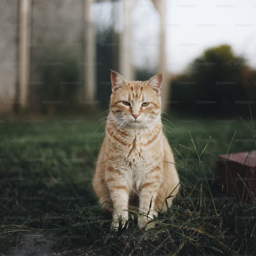

In [9]:
editing_data = image_data[4]
path, source_caption, target_caption = (
    editing_data["path"],
    editing_data["source_caption"],
    editing_data["target_caption"],
)
print(source_caption)
print(target_caption)
images = load_image(path)
images.resize((256, 256))

#### Real editing

In [10]:
# source_caption = "a cat"
# target_caption = "a egg"


source_image = pil_to_tensor(images, device)

In [11]:
self_replace_steps = 0.8
NUM_DIFFUSION_STEPS = 50

# invert the source image
start_code, latents_list = pipe.invert(
    source_image,
    source_caption,
    guidance_scale=7.5,
    num_inference_steps=50,
    return_intermediates=True,
)


latents = torch.randn(start_code.shape, device=device)
prompts = [source_caption, target_caption]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(
    prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps
)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(
    prompts,
    latents=start_code,
    guidance_scale=7.5,
    ref_intermediate_latents=latents_list,
)

DDIM Sampler: 100%|██████████| 50/50 [00:09<00:00,  5.01it/s]


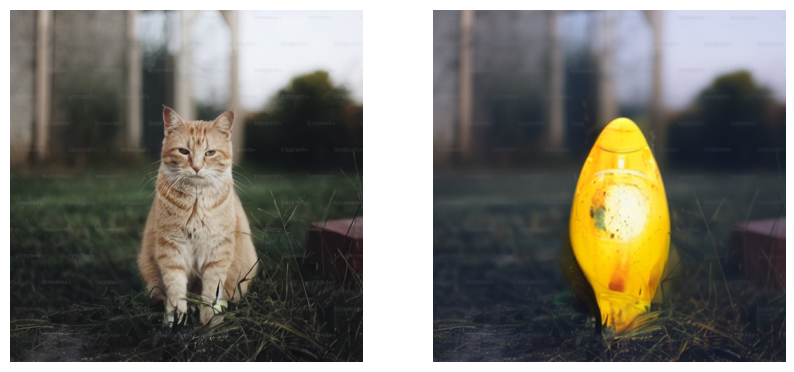

In [12]:
def plot_results(images):
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).astype(np.uint8)


    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

plot_results(results)